# Analysis of $Mo_{1-x}Re_xS_2$ images

**Extract statistically significant information about effective interactions between Mo and Re atoms**

## Table of Contents

* [1. Images](#1.-Images)
* [2. Target and random histograms](#2.-Target-and-random-histograms)
* [3. Statistical distance profiles](#3.-Statistical-distance-profiles)
* [4. Statistical significance analysis](#4.-Statistical-significance-analysis)
* [5. Conclusions](#5.-Conclusions)

**Notebook setup**

In [1]:
%matplotlib inline

import os
import sys
import copy
import pickle
from collections import Counter
from itertools import product, combinations
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.stats import norm, chi2
from scipy.optimize import fmin

from subprocess import Popen, PIPE
import multiprocessing as mp

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('../../../force_fields/statmechlib')
from statmechlib.read_write import read_lattice_model, read_modeldef, write_modeldef
from statmechlib.preprocessing import get_stats_latt
from statmechlib.forcefields import sd2

sys.path.append('../src/utils')
from utils import *

In [4]:
np.random.seed(42)
data_dir = '../data/raw'
sim_dir = '../src/code'

## 1. Images

Extract Mo and Re positions for each image

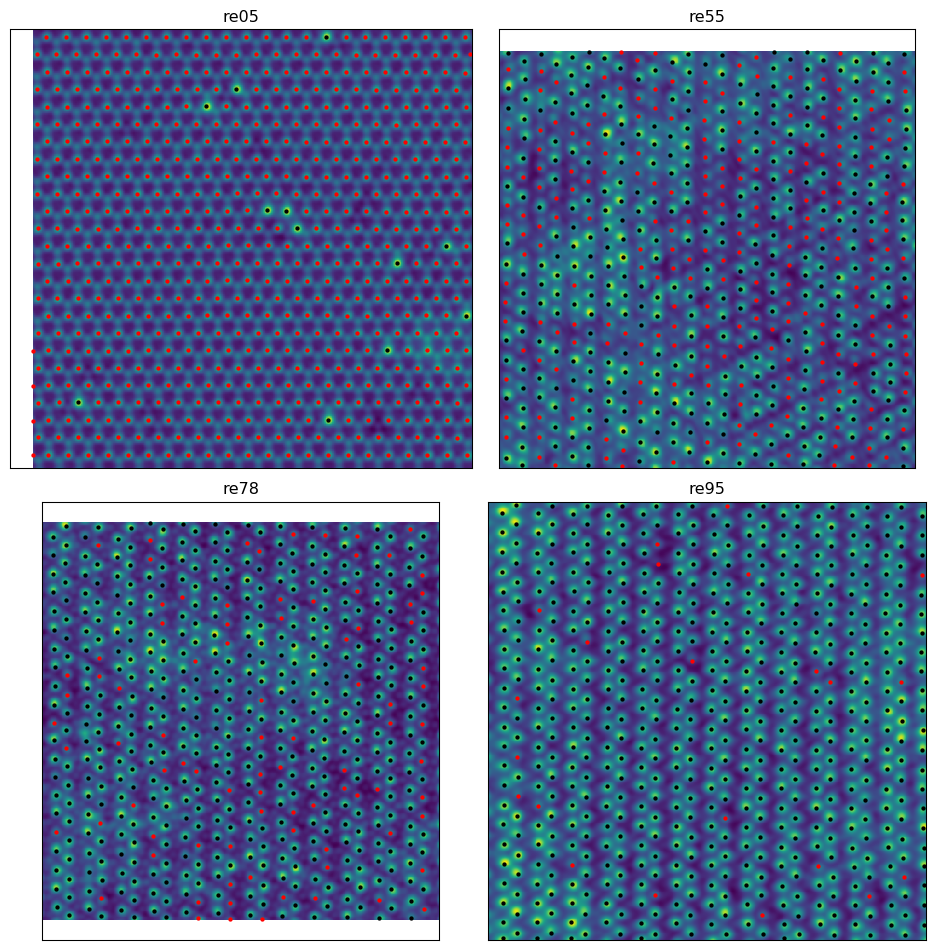

In [5]:
# select relevant atomic coordinates for further analysis
# different files store different atoms in centroids_1 and centroids_2 -> sort this out
names = ['re05', 're55', 're78', 're95'] # hdf5 file name roots

# Separate atoms to Mo and Re based on image-specific intensity threshold
intensity_thresh = [0.80, 0.45, 0.45, 0.45]  # intensity thresholds for each image
atom_pos, atom_ids, intensities = get_atom_positions(data_dir, names, intensity_thresh)

show_images(names, atom_pos, atom_ids, intensities)

### Identify distinct local configurations and collect target histograms

In [6]:
distance_thresh = [45, 32, 30, 26]  # distance thresholds for each image
target_hist, num_samples = collect_target_histograms(names, atom_pos, atom_ids, distance_thresh)

cfg_types = sorted(set([c for h in target_hist.values() for c in h]))

# symmetry number for each configuration
conf_counts, conf_dict, trans_hist = config_symmetry_numbers(cfg_types)

#trans_hist = make_transform_matrix(cfg_types, conf_dict)

# probability of each symmetrized configuration for a given Re concentration
x_re = rhenium_concentration(target_hist)

# random - null hypothesis
prob_conf = random_config_proba(names, conf_counts, x_re)

# applies uninformative multinomial (Jeffrey's) prior to deal with low-sampling-caused zero counts
target_hist_adjusted = apply_prior(names, conf_counts, cfg_types, target_hist, prob_conf)

# get estimated probability distribution of the target for model optimization
gsv = get_probability_histogram(names, cfg_types, target_hist_adjusted)
#gsv = get_probability_histogram(names, cfg_types, target_hist)

## 2. Target and random histograms

**Comparison of target (adjusted) and random (null) histograms of local configurations**

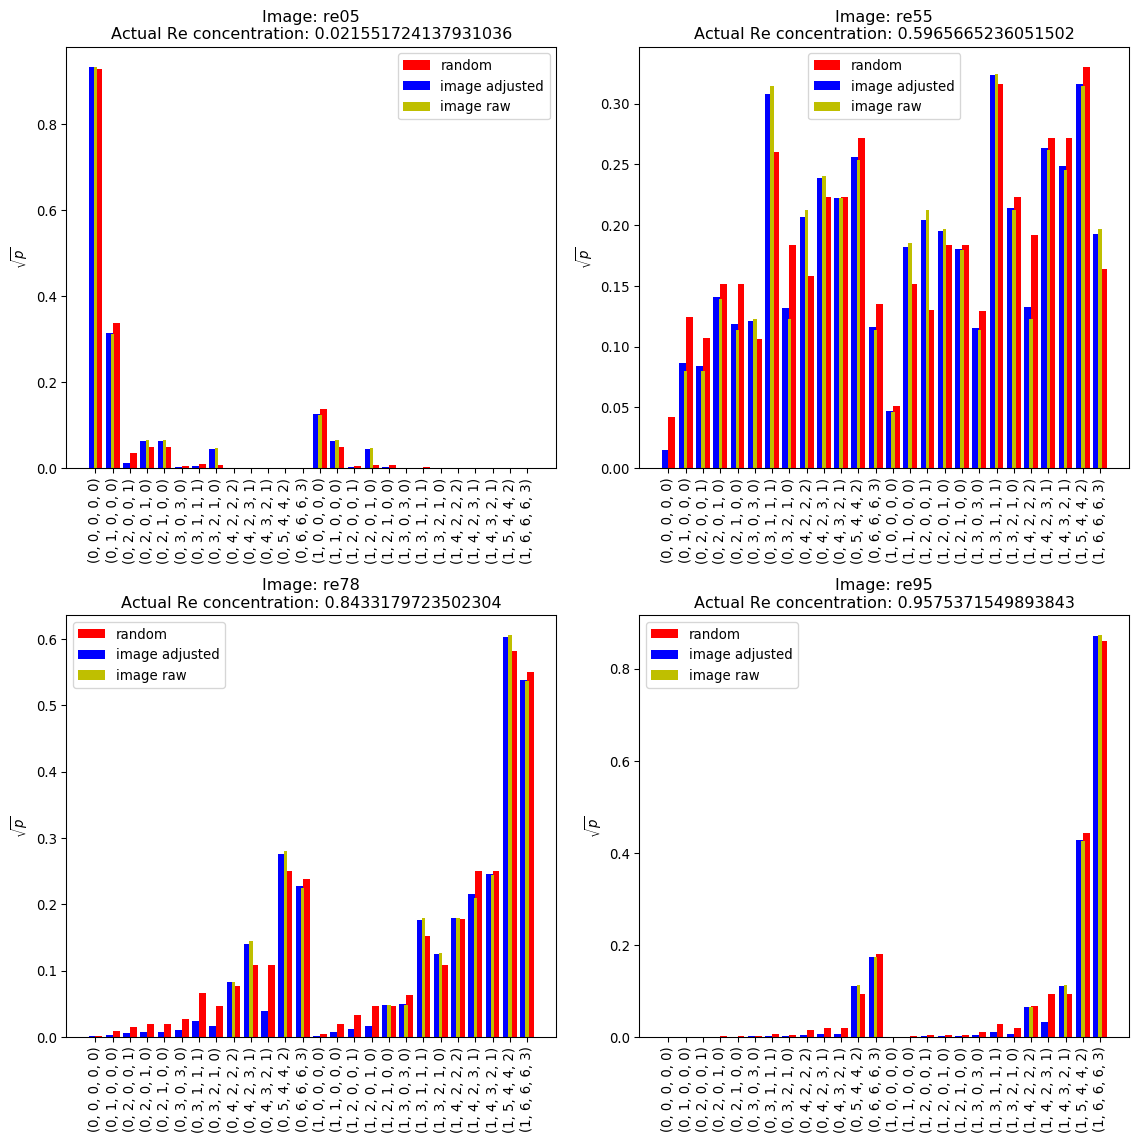

In [7]:
plot_histograms(names, num_samples, target_hist, target_hist_adjusted, prob_conf, cfg_types, x_re)

In [8]:
# define data sets for which parameters will be optimized
all_datasets = {0:tuple(names)}
all_datasets.update({i:s for i, s in enumerate(combinations(names, 3), len(all_datasets))})
all_datasets.update({i:s for i, s in enumerate(combinations(names, 2), len(all_datasets))})
all_datasets.update({i:s for i, s in enumerate(combinations(names, 1), len(all_datasets))})
#print(all_datasets)

### Read input data from refrence simulations

In [9]:
dset = all_datasets[0]
input_datax = {}

for key in ['null_', '0_m2_', '0_p2_', 'm2_0_', 'p2_0_']:

    # directory names
    dirnames = [key + s for s in dset]
    data_paths = [os.path.join(sim_dir, dname) for dname in dirnames]

    # get reference parameters
    pars_ref = read_mld(data_paths, read_modeldef)
    pars_in = np.array([pars_ref[1], pars_ref[4]])

    # read reference data
    trjs = read_outputs(dset, data_paths, read_lattice_model)
        
    # select the equilibrated part of the trajectories
    trjs = trajectory_range(trjs, imin=1000)
        
    # get histograms of symmetrized configurations
    hsv = make_reference_histograms(trjs, trans_hist)
    for key_hsv, val in hsv.items():
        #print('n_eff:', n_effective(val))
        pass

    # get statistics of lattice model energetics
    hsu = make_energy_statistics(trjs)
        
    # make targets and statistics for optimization with selected names
    targets = make_targets(gsv, num_samples)
    stats = make_stats(trjs, hsu, hsv)

    # select statistics and targets relevant for dset 
    stats_opt = {s:stats[s] for s in dset}
    targets_opt = {s:targets[s] for s in dset}

    # optimize parameters
    input_datax[key] = {'params':pars_in, 'stats':stats_opt, 'targets':targets_opt}

In [14]:
# save input into a pickle
with open('../data/working/input_data_tight2.pickle', 'wb') as fo:
    pickle.dump(input_datax, fo)

In [11]:
with open('../data/working/input_data_tight2.pickle', 'rb') as fi:
    input_datax = pickle.load(fi)

### Functions for combining data from reference simulations

In [16]:
def df_geom(params_list, X_list):
    """Calculates free energy differences between reference systems using geometric estimates.
    
    Parameters
    ----------
    params_list : list of k ndarrays
        list of k parameter lists of n_params length for k systems
    X_list : list of k ndarrays shape(n_samples, n_params)
        configurational statistics needed for energy computation
    
    Returns
    -------
    df : ndarray, shape (k, k)
        pairwise free energy differences
    """
    
    Ktot = len(params_list)
    
    # Calculate energy list len(u)=k of ndarrays, shape(n, k)
    params_mat = np.array(params_list)  # shape (k, p)
    us = [X.dot(params_mat.T) for X in X_list]
    
    #print(np.array([np.mean(X.dot(p)) for p, X in zip(params_list, X_list)]))

    df = np.zeros((Ktot, Ktot), dtype=np.float64)
    
    # Create a (k, k) matrices of free energy estimates and Bhattacharyya coefficients
    for k in range(Ktot):
        for j in range(k+1, Ktot):

            du_jk = -0.5*(us[k][:, j] - us[k][:, k])
            du_ave_jk = np.mean(du_jk)
            du_jk -= du_ave_jk 
            exp_jk = np.mean(np.sort(np.exp(du_jk)))
            
            du_kj = -0.5*(us[j][:, k] - us[j][:, j])
            du_ave_kj = np.mean(du_kj)
            du_kj -= du_ave_kj
            exp_kj = np.mean(np.sort(np.exp(du_kj)))
            
            df[k, j] = -(np.log(exp_jk/exp_kj) + (du_ave_jk - du_ave_kj))
            df[j, k] = -df[k, j]
        
    return df

In [17]:
def average_histogram(params, ref_params_list, X_list, df, hist_list):
    """Combines histogram data from different simulations using MBAR"""
    
    params_mat = np.array(ref_params_list)  # shape (k, p)
    # k lists of ndarrays shape(n_k, k)
    hst = np.concatenate(hist_list, axis=0)
    X = np.concatenate(X_list, axis=0)
    us = X.dot(params_mat.T)

    # k lists of ndarrays shape (n_k,) (new energies for all configurations)
    u_new = X.dot(params[:, None])
    
    # Number of samples for each system
    Ns = np.array([Xi.shape[0] for Xi in X_list])

    us -= u_new
    us = df - us
    us_max = np.max(us)
    us -= us_max
    
    sum_k = np.sum(Ns*np.exp(us), axis=1)
        
    c_a = np.sum(1.0/sum_k)
    c_hist = np.sum(hst/sum_k[:, None], axis=0)
    hist_ave = c_hist/c_a
        
    return hist_ave

## 3. Statistical distance profiles

Calculate 2D profiles as a function of model parameters.
Plot separately distances for individual image histograms and then for the combined data.

In [18]:
# Set up data for statistical distance calculation
inp_data = list(input_datax.items())

params_list = [np.array(inp[1]['params']) for inp in inp_data]
X_list = {}
hist_list = {}
hist_targ = {}
df_est = {}
for key in names:
    X_list[key] = [inp[1]['stats'][key]['interaction_stats'][:,(1, 4)] for inp in inp_data]
    hist_list[key] = [inp[1]['stats'][key]['config_stats'] for inp in inp_data]
    hist_targ[key] = [inp[1]['targets'][key]['config_stats'] for inp in inp_data][0]
    df_est[key] = df_geom(params_list, X_list[key])

In [19]:
ngrid = 20
scale = np.array([0.4, 0.4])

s2_profiles = {}
pars_profiles = {}
for key in names:
    s2_profiles[key] = np.empty((2*ngrid+1, 2*ngrid+1), dtype=float)
    pars_profiles[key] = np.empty((2*ngrid+1, 2*ngrid+1, 2), dtype=float)
    for i, j in product(range(-ngrid, ngrid+1), repeat=2):
        x = float(i)/(ngrid)
        y = float(j)/(ngrid)
        pars_in = np.array([x, y])*scale
        hist_ave = average_histogram(pars_in, params_list, X_list[key], df_est[key][0], hist_list[key])
        cb1 = np.sqrt(hist_ave).dot(np.sqrt(hist_targ[key]))
        s2 = np.arccos(cb1)**2

        s2_profiles[key][i+ngrid, j+ngrid] = s2
        pars_profiles[key][i+ngrid, j+ngrid, :] = pars_in

### Distances for individual images

* Dark blue: minima
* Yellow: maxima
* The color scales are different in each image

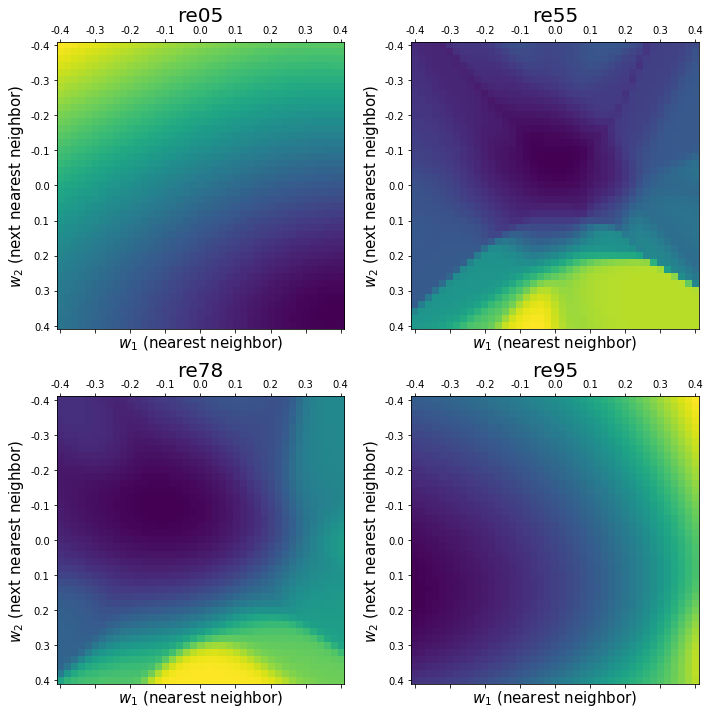

In [23]:
ticklabels = [round(x, 1) for x in np.linspace(-0.5, 0.4, 10)]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i, (key, out_data) in enumerate(s2_profiles.items()):
    ir, ic = divmod(i, 2)
    im = axes[ir, ic].matshow(out_data)
    axes[ir, ic].set_title(key, fontsize=20)
    axes[ir, ic].set_xticklabels(ticklabels)
    axes[ir, ic].set_yticklabels(ticklabels)
    axes[ir, ic].set_xlabel('$w_1$ (nearest neighbor)', fontsize=15)
    axes[ir, ic].set_ylabel('$w_2$ (next nearest neighbor)', fontsize=15)
    indices = np.unravel_index(np.argmin(out_data, axis=None), out_data.shape)
#     print(np.min(out_data), indices)
#     print('params', pars_profiles[key][indices])

plt.tight_layout()

### Distance to the combined target data

Text(0.5, 1.05, 'Total\n Optimal parameters: [-0.06 -0.04]')

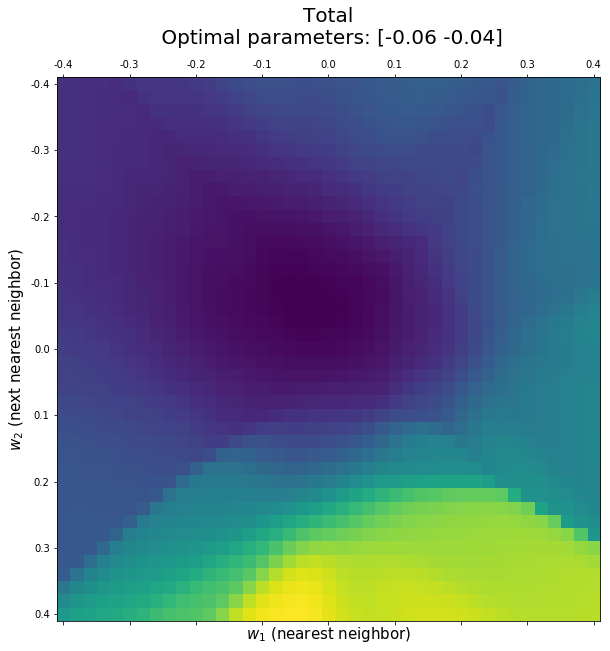

In [24]:
s2_combined = sum(list(s2_profiles.values()))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
im = axes.matshow(s2_combined)
indices = np.unravel_index(np.argmin(s2_combined, axis=None), s2_combined.shape)
axes.set_xticklabels(ticklabels)
axes.set_yticklabels(ticklabels)
axes.set_xlabel('$w_1$ (nearest neighbor)', fontsize=15)
axes.set_ylabel('$w_2$ (next nearest neighbor)', fontsize=15)
pars_optimal = pars_profiles['re55'][indices]
axes.set_title('Total\n Optimal parameters: ' + str(pars_optimal), fontsize=20)

### Notes

The profiles for medium concentrations exhibit reasonably well-defined minima close to (0, 0).
The profiles for extreme concentrations are farther from random system (0, 0), but the absolute value of statistical distance is very small and does not influence noticeably the combined distance, which is determined mustly by the medium systems.

## 4. Statistical significance analysis

Statistical distance $s$ can be used directly for calculating p-values. It represents the distance between the center of our hypothesis distribution (null or a model), which has a roughly multivariate Gaussian shape in the $\sqrt{p}$ coordinates, and the observed distribution (target histogram). To calculate the p-value, we determine the probability that a sample from our hypothesis distribution is at least as distant as the target sample. This is achieved by integrating the multivariate normal distribution beyond distance $s$, which corresponds to $1 - \chi^2_k(s)$, where $k$ is the degrees of freedom. For our histogram with 26 bins (local configurations) and one constraint on the sum of probabilities, $k$ is 25.

In [25]:
pars_all = {
    'null': np.array([0.0, 0.0]),
    'optimal': pars_optimal
}

s2_vals = {}
for key, pars_in in pars_all.items():
    s2_vals[key] = {}
    for name in names:
        hist_ave = average_histogram(pars_in, params_list, X_list[name], df_est[name][0], hist_list[name])
        cb1 = np.sqrt(hist_ave).dot(np.sqrt(hist_targ[name]))
        s2_vals[key][name] = np.arccos(cb1)**2

### Null hypothesis - random distribution (zero interactions)

In [26]:
s2_tot = 0.0
n_tot = 0
print('Null')
print('Parameters:', *pars_all['null'], '\n')

for name in names:
    s2 = s2_vals['null'][name]
    s2_tot += s2
    n = num_samples[name]
    n_tot += n
    print('System:', name)
    print('Number of samples:', n)
    print('Statistical distance:', s2)
    print('p-value:', 1-chi2.cdf(n*4*s2, 25))
    print('')
    
print('System: Combined')
print('Number of samples:', n_tot)
print('Statistical distance:', s2_tot)
print('p-value:', 1-chi2.cdf(n_tot*4*s2_tot, 100))
print('')

Null
Parameters: 0.0 0.0 

System: re05
Number of samples: 464
Statistical distance: 0.004583302448613321
p-value: 0.9991339289104233

System: re55
Number of samples: 466
Statistical distance: 0.024333230349316195
p-value: 0.007612245634646242

System: re78
Number of samples: 434
Statistical distance: 0.014384400236994766
p-value: 0.4639819944622888

System: re95
Number of samples: 471
Statistical distance: 0.005767479334653138
p-value: 0.9935761477981314

System: Combined
Number of samples: 1835
Statistical distance: 0.04906841236957742
p-value: 0.0



### Best model

In [27]:
print('Optimized')
print('Parameters:', *pars_all['optimal'], '\n')

s2_tot = 0.0
n_tot = 0
for name in names:
    s2 = s2_vals['optimal'][name]
    s2_tot += s2
    n = num_samples[name]
    n_tot += n
    print('System:', name)
    print('Number of samples:', n)
    print('Statistical distance:', s2)
    print('p-value:', 1-chi2.cdf(n*4*s2, 25))
    print('')
    
print('System: Combined')
print('Number of samples:', n_tot)
print('Statistical distance:', s2_tot)
print('p-value:', 1-chi2.cdf(n_tot*4*s2_tot, 100))
print('')

Optimized
Parameters: -0.06 -0.04000000000000001 

System: re05
Number of samples: 464
Statistical distance: 0.005012984974308304
p-value: 0.9981445869227669

System: re55
Number of samples: 466
Statistical distance: 0.021699158716172236
p-value: 0.02622228008396521

System: re78
Number of samples: 434
Statistical distance: 0.012335425560349486
p-value: 0.6692958418379679

System: re95
Number of samples: 471
Statistical distance: 0.005753467366540802
p-value: 0.9936948729154246

System: Combined
Number of samples: 1835
Statistical distance: 0.04480103661737083
p-value: 0.0



## 5. Conclusions

The random model (null hypothesis) is in a decent agreement with the configuration statistics, except for the Re55 image, where it would not pass the standard significance of 0.05 or 0.01 (these values are quite arbitrary, though). However, for the combined set of target images, this model would fail.

The optimized model, whose parameters are close to 0, improves the match for the medium Re concentrations. It would pass the 0.01 level but, in general, the improvement is quite undewhelming. Again, it would completely fail for the combined set of target data. This failure comes down to the larger number of samples (four times of individual images)

### Some additional thoughts

Assuming that the patterns originate from particle interactions, it seems a bit odd that the Mo-Re interaction would be attractive. A closer look at the images suggests that the like pairs (Mo-Mo & Re-Re) prefer formation of blocks (diamond-shaped group of 4 atoms of the same type) or lines (atom pairs). However there is a good chance that this block may be surrounded by the other element and, as a result, the average interaction may seem attractive for Mo-Re.

The patterns seen in the images look anisotropic, which our model does not reproduce. If there is a preferred number of neighbors of each type, including manybody interactions using simple bond valence terms may potentially improve description for medium concentrations but also for extreme concentrations that seem to suggest attractions between like atoms. (This may be stretching the noisy data too far).